## Related links for BERT-for-QA
1. BERT uses SQuAD v1.1 dataset for training. 
2. [SQuAD Dataset Link](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Super_Bowl_50.html?model=r-net+%20(ensemble)%20(Microsoft%20Research%20Asia)&version=1.1)
3. [Our used model Link](https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad?fbclid=IwAR0ahQVEOYymV9bbiIss2nsCJh6BXyMXAOyZERjrVXiyUL1RN1txftWYlhU)
4. [The paper of the proposed Model](https://arxiv.org/abs/1810.04805)

### BERT large model (uncased) whole word masking finetuned on SQuAD
- BERT is a transformers model pretrained on a large corpus of English data in a self-supervised fashion. This means it was pretrained on the raw texts only, with no humans labelling them in any way (which is why it can use lots of publicly available data). More precisely, it was pretrained with two objectives:
  - Masked language modeling (MLM): taking a sentence, the model randomly masks 15% of the words in the input then run the entire masked sentence through the model and has to predict the masked words. It allows the model to learn a bidirectional representation of the sentence.
  - Next sentence prediction (NSP): the models concatenates two masked sentences as inputs during pretraining. Sometimes they correspond to sentences that were next to each other in the original text, sometimes not. The model then has to predict if the two sentences were following each other or not.
- This model has the following configuration: 24-layer, 1024 hidden dimension, 16 attention heads, 336M parameters.

### BERT I/P Format:
- To feed BERT model, we pack both the question and the reference text into the input. 
- Tokens are separated as: **[CLS] [Question]...[Tokens] [Sep] [Context]...[Tokens]**
- BERT also uses "Segment Embeddings" to differentiate the question from the reference text. These are simply two embeddings (for segments "A" and "B")
<img src="https://github.com/SaiferGit/Hands-On-QA/blob/main/Snapshots/input_formatting.png" width=700>

### Start and End Token Classifier:

- start token classification:

<img src="https://github.com/SaiferGit/Hands-On-QA/blob/main/Snapshots/start_token_classification.png" width="750"> 

- end token classification:

<img src="https://github.com/SaiferGit/Hands-On-QA/blob/main/Snapshots/end_token_classification.png" width="500" align='center'>




In [ ]:
!pip install transformers --quiet
from IPython.display import display # for ipynb display
from IPython.html import widgets # for ipynb display
import torch
import time

In [ ]:
# For Question Answering we use the BertForQuestionAnswering class from the transformers library.
# This class is already pre-trained, we fine-tuned it with SQuAD Dataset v1.1, it's not outputting whether the question is "impossible" to answer from the text (which is part of the task in v2 of SQuAD).
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [ ]:
# Load the tokenizer 
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

### Asking a Question

In [ ]:
question = "What are the public holidays of Bangladesh?"
answer_text = "including monitoring of sighting of the moon in accordance with the lunar Islamic calendar in order to set festival dates; as well as the charitable tradition of zakat. Public holidays include the Islamic observances of Eid-ul-Fitr, Eid-al-Adha, the Prophet's Birthday, Ashura and Shab-e-Barat."

We'll need to run the BERT tokenizer against both the `question` and the `answer_text`. To feed these into BERT, we actually concatenate them together and place the special [SEP] token in between.

In [ ]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 84 tokens.


BERT only needs the token IDs, but for the purpose of inspecting the tokenizer's behavior, let's also get the token strings and display them. Printing out the tokens with their IDs

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<10} {:>3,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]      101
what       2,054
are        2,024
the        1,996
public     2,270
holidays   11,938
of         1,997
bangladesh 7,269
?          1,029

[SEP]      102

including  2,164
monitoring 8,822
of         1,997
sighting   29,426
of         1,997
the        1,996
moon       4,231
in         1,999
accordance 10,388
with       2,007
the        1,996
lunar      11,926
islamic    5,499
calendar   8,094
in         1,999
order      2,344
to         2,000
set        2,275
festival   2,782
dates      5,246
;          1,025
as         2,004
well       2,092
as         2,004
the        1,996
charitable 11,128
tradition  4,535
of         1,997
za         23,564
##kat      24,498
.          1,012
public     2,270
holidays   11,938
include    2,421
the        1,996
islamic    5,499
ob         27,885
##ser      8,043
##vances   26,711
of         1,997
e          1,041
##id       3,593
-          1,011
ul         17,359
-          1,011
fit        4,906
##r        2,099
,          1,010
e    

We've concatenated the question and answer_text together, but BERT still needs a way to distinguish them.

BERT has two special "Segment" embeddings: `Segment A` for Question tokens and `Segment B` for Contexts/answer_text tokens.

Then before feeding this into with BERT layers, we first concatenate `Segment A` embeddings with Question tokens and then `Segment B` embeddings with answer_text tokens. These additions are already handeled by `transformer` library. We just need to specify '0' and '1' for each token.

In the `transformers` library, huggingface likes to call these `token_type_ids`, but BERT paper uses `segment_ids` instead. 

In [ ]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id) # returning first index of [SEP] token

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b
print(segment_ids)

# There should be a segment_id for every input token.
# The assert keyword lets you test if a condition in your code returns True, if not, the program will raise an AssertionError. 
assert len(segment_ids) == len(input_ids), "length does not match, your segment_ids length does not match with number of tokens"

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


We're ready to feed our example into the model!

In [ ]:
# Run our example through the model.
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True) 

# Span-start scores (before SoftMax)
start_scores = outputs.start_logits 
print(start_scores)
# Span-end scores (before SoftMax)
end_scores = outputs.end_logits 
print(end_scores)

tensor([[-5.9127, -4.5799, -6.2805, -5.9091, -6.6841, -7.3693, -6.9432, -5.1894,
         -8.6772, -5.9126, -6.2916, -4.7875, -8.0206, -4.9869, -8.3989, -8.2482,
         -6.3489, -8.3123, -7.5380, -8.1773, -7.0380, -5.0207, -4.6673, -6.1177,
         -8.3096, -8.0275, -7.6229, -6.4729, -4.0683, -6.1991, -8.1525, -7.7648,
         -7.9924, -8.1408, -5.9551, -4.3948, -5.7733, -7.6992, -5.6835, -6.9369,
         -5.9126,  2.3565, -2.4022,  0.4396,  4.6195,  5.3954, -0.2186, -3.2802,
         -2.4137, -2.9397,  5.6666, -3.0419, -5.0751, -4.7666, -5.5023, -4.9921,
         -4.9605, -3.7193, -2.0489, -5.2415, -6.4632, -5.3962, -7.2315, -5.8659,
         -5.3283, -4.6710, -1.5938, -3.9851, -6.4203, -6.6945, -4.6286, -5.6478,
         -1.6155, -5.6244, -5.0549, -3.4503, -5.7233, -6.8241, -6.1427, -7.0829,
         -5.9187, -4.2400, -4.4023, -5.9126]], grad_fn=<SqueezeBackward1>)
tensor([[-1.0389, -4.5786, -5.8303, -6.7499, -7.5687, -5.9852, -6.1440, -4.6431,
         -6.7921, -1.0388, -7.8035

Now we can highlight the answer just by looking at the most probable start and end words.

In [ ]:
# Find the tokens with the highest `start` and `end` scores.
# torch.argmax Returns the indices of the maximum value of all elements in the input tensor.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: ' + answer)

Answer: e ##id - ul - fit ##r , e ##id - al - ad ##ha , the prophet ' s birthday , ash ##ura and sha ##b - e - bar ##at


Reconstructing any words that got broken down into subwords.

In [ ]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "eid - ul - fitr , eid - al - adha , the prophet ' s birthday , ashura and shab - e - barat"


### Visualizing Scores

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


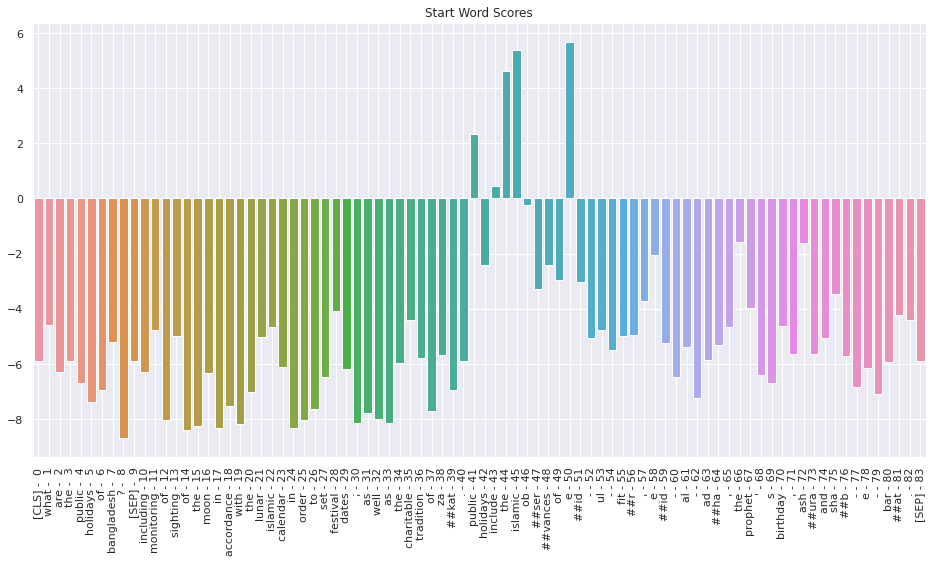

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

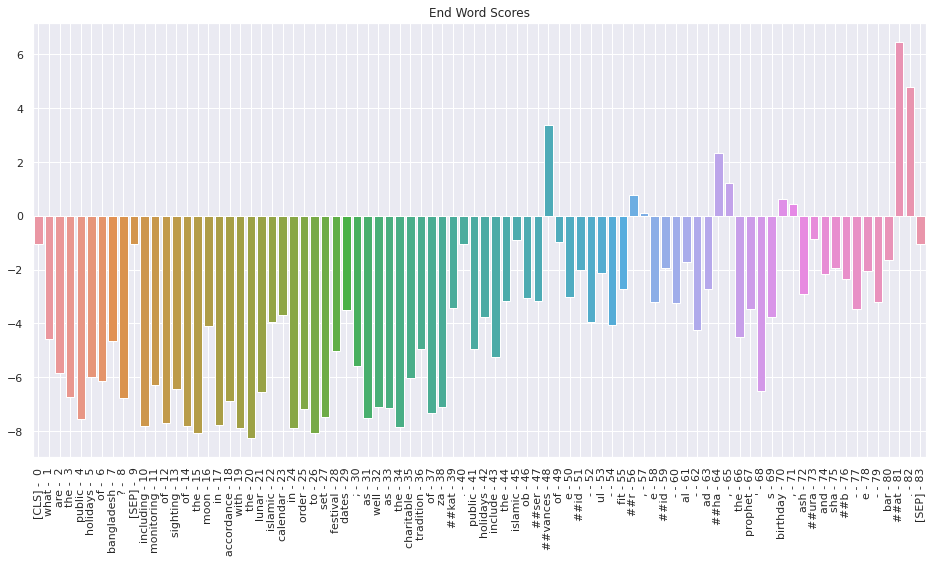

In [ ]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [ ]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


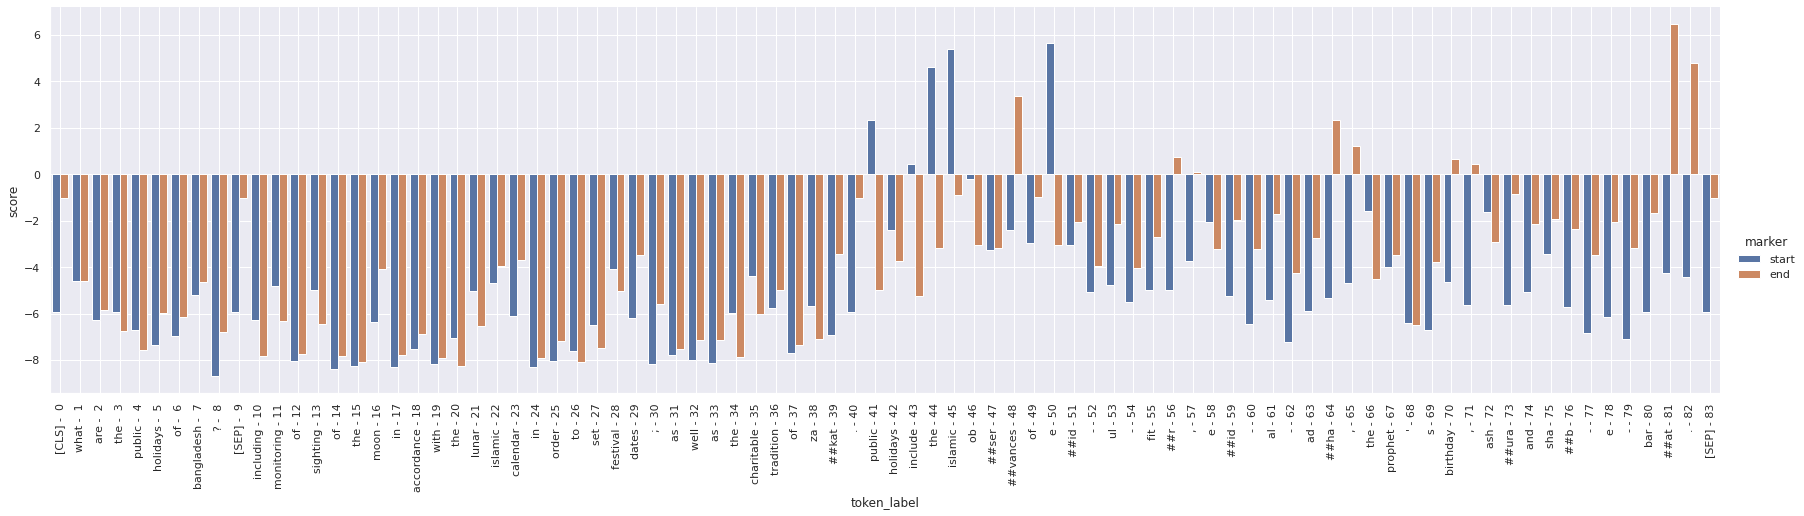

In [ ]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


### Defining All The Codes into A Method

In [ ]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [ ]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=120) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations
from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and
right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference,
without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It
obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to
80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question
answering Test F1 to 93.2 (1.5 point absolute improvement) 

In [ ]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Query has 258 tokens.

Answer: "bidirectional encoder representations from transformers"


In [ ]:
question = "What are some example applications of BERT?"

answer_question(question, bert_abstract)

Query has 255 tokens.

Answer: "question answering and language inference"


In [ ]:
start_time = time.time()
question = "What are the public holidays of Bangladesh?"
answer_text = "including monitoring of sighting of the moon in accordance with the lunar Islamic calendar in order to set festival dates; as well as the charitable tradition of zakat. Public holidays include the Islamic observances of Eid-ul-Fitr, Eid-al-Adha, the Prophet's Birthday, Ashura and Shab-e-Barat."

answer_question(question, answer_text)
print("--- %s seconds ---" % (time.time() - start_time))

Query has 84 tokens.

Answer: "eid - ul - fitr , eid - al - adha , the prophet ' s birthday , ashura and shab - e - barat"
--- 1.264247179031372 seconds ---


## DistilBERT implementation
1. [DistilBERT Paper](https://arxiv.org/abs/1910.01108)
2. Used model [Link](https://huggingface.co/distilbert-base-uncased-distilled-squad)
3. [Huggingface All Pretrained Model List](https://huggingface.co/transformers/pretrained_models.html)
4. DistilBERT doesn’t have token_type_ids, you don’t need to indicate which token belongs to which segment. Just separate your segments with the separation token tokenizer.sep_token (or [SEP]).
5. All functions of DistilBERT is [here](https://huggingface.co/transformers/model_doc/distilbert.html)

In [ ]:
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizer
DistilBERTmodel = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')
DistilBERTtokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_token_type_ids=True)

def getOutputFromDistil(Dquestion, Danswer_text):
  # ======== Tokenize ========
  # Apply the tokenizer to the input text, treating them as a text-pair.
  DistilBERTinput_ids = DistilBERTtokenizer.encode(question, answer_text)

  # Report how long the input sequence is.
  print('Query has {:,} tokens.\n'.format(len(DistilBERTinput_ids)))

  # ======== Evaluate ========
  # Run our example through the model.
  outputs = DistilBERTmodel(torch.tensor([DistilBERTinput_ids]), # The tokens representing our input text.
                return_dict=True) 

  start_scores = outputs.start_logits
  end_scores = outputs.end_logits

  # ======== Reconstruct Answer ========
  # Find the tokens with the highest `start` and `end` scores.
  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)

  # Get the string versions of the input tokens.
  tokens = DistilBERTtokenizer.convert_ids_to_tokens(DistilBERTinput_ids)

  # Start with the first token.
  answer = tokens[answer_start]

  # Select the remaining answer tokens and join them with whitespace.
  for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

  print('Answer: "' + answer + '"')


question = "What are the public holidays of Bangladesh?"
answer_text = "including monitoring of sighting of the moon in accordance with the lunar Islamic calendar in order to set festival dates; as well as the charitable tradition of zakat. Public holidays include the Islamic observances of Eid-ul-Fitr, Eid-al-Adha, the Prophet's Birthday, Ashura and Shab-e-Barat."
start_time = time.time()
getOutputFromDistil(question, answer_text)
print("--- %s seconds ---" % (time.time() - start_time))

Query has 84 tokens.

Answer: "eid - ul - fitr , eid - al - adha , the prophet ' s birthday , ashura and shab - e - barat"
--- 0.17598509788513184 seconds ---


In [ ]:
question = "Who was the founder of facebook?"
answer_text = "Facebook (stylized as facebook) is an American online social media and social networking service based in Menlo Park, California, and a flagship service of the namesake company Facebook, Inc. It was founded by Mark Zuckerberg, along with fellow Harvard College students and roommates Eduardo Saverin, Andrew McCollum, Dustin Moskovitz, and Chris Hughes."

start_time = time.time()
getOutputFromDistil(question, answer_text)
end_time = time.time()
DistilBERTtime_taken = end_time - start_time
print("---DistilBERT Got the answer in: %s seconds ---" % DistilBERTtime_taken)

start_time = time.time()
answer_question(question, answer_text)
end_time = time.time()
BERTtime_taken = end_time - start_time
print("---BERT Got the answer in: %s seconds ---" % BERTtime_taken)


total_time = DistilBERTtime_taken + BERTtime_taken
faster = (BERTtime_taken - DistilBERTtime_taken)*100
faster = faster/total_time
print("==============\n   DistilBERT is:  ")
print(faster) 
print("% faster than BERT  \n  ==============")
# print("---%d\% faster than BERT ---" % (faster))

Query has 83 tokens.

Answer: "mark zuckerberg"
---DistilBERT Got the answer in: 0.1824321746826172 seconds ---
Query has 83 tokens.

Answer: "mark zuckerberg"
---BERT Got the answer in: 1.2376108169555664 seconds ---
   DistilBERT is:  
74.30610541274379
% faster than BERT  
